In [1]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preperation

- Saving all the CSVs with descriptive names in the Folder ./original_data
- In case of XML Files the were converted to CSVs

### Google Data:

- Manuel removal of the first two rows and the region (Deutschland)
- To get weekly Data it was necessary to download several 5 year intervals and normalize/stitching them together
- Logarithmierung: Yes, because search interest data often exhibits exponential growth or decay, and log transformation helps stabilize variance and linearize trends.

### AGPI & Gebrauchtwagenpreiseindex:

- Only available on a monthly basis values were assigned to the last day of the month
- Logarithmierung: Yes, because price indices can show multiplicative effects over time, and logs convert these to additive effects, stabilizing variance.

### Arbeitslosenzahlen:

- Loaded from CSV, cleaned numeric columns (removing thousands separators, converting to appropriate types).
- 'Berichtsmonat' (reporting month) string converted to datetime objects, set to the last day of the month.
- Logarithmierung: No, the raw figures were used directly as they represent counts and rates which are often analyzed in their original scale or after differencing for stationarity.

### Euribor:

- Data for 3-month, 6-month, and 12-month Euribor rates loaded from separate CSVs.
- Unnecessary "TIME PERIOD" column dropped and columns renamed for clarity.
- Dates were already in a usable monthly format.
- Logarithmierung: No, interest rates are typically analyzed in their original percentage scale, especially when they can be near zero or negative, where logs are undefined or behave poorly.

### ifo Beschäftigungsbarometer:

- Loaded from CSV.
- "DATE" column converted to datetime objects, set to the last day of the month, then formatted as string "YYYY-MM-DD".
- Logarithmierung: No, index values like this are often used directly or differenced.

### ifo Geschäftsklima:

- Loaded from CSV.
- "DATE" column (originally in "MM/YYYY" format) converted to datetime objects, set to the last day of the month, then formatted as string "YYYY-MM-DD".
- Logarithmierung: No, similar to the Beschäftigungsbarometer, these index values are typically analyzed in their original scale.

### BMW Sales:

- Loaded from CSV, with specified separator and decimal character.
- "DATE" column converted to datetime objects.
- Logarithmierung: Yes, sales data can exhibit multiplicative seasonality and growth, log transformation helps in stabilizing variance and making the series more amenable to time series modeling.

### Verbraucherpreisindex:

- Loaded from CSV, with specified separator and decimal character.
- Numeric columns representing various price indices cleaned (commas replaced with dots, converted to float).
- "Datum" (Date) column converted to datetime objects, set to the last day of the month.
- Logarithmierung: Yes, for the selected index columns, as price indices often have multiplicative components and log transformation helps in stabilizing variance and interpreting changes as percentage changes.


In [2]:
# Log transform helper functions
def log_transform_series(series_to_log):
    return np.log(series_to_log.replace(0, np.nan))


def create_log_transformed_df(
    input_df, value_col_name, new_log_col_name, date_col_name="DATE"
):
    df_log = pd.DataFrame()
    df_log[date_col_name] = input_df[date_col_name]
    df_log[new_log_col_name] = log_transform_series(input_df[value_col_name])
    return df_log

In [3]:
# google trends
def merge_and_normalize_trends(dfs, col_name):
    # Start with the first DataFrame
    result = dfs[0].copy()
    for next_df in dfs[1:]:
        # Find overlap
        overlap = set(result["Woche"]) & set(next_df["Woche"])
        if overlap:
            # Use the mean ratio in the overlap to normalize
            overlap = list(overlap)
            result_overlap = result[result["Woche"].isin(overlap)].set_index("Woche")
            next_overlap = next_df[next_df["Woche"].isin(overlap)].set_index("Woche")
            ratio = result_overlap[col_name].mean() / next_overlap[col_name].mean()
        else:
            ratio = 1.0
        # Normalize next_df
        next_df_norm = next_df.copy()
        next_df_norm[col_name] = next_df_norm[col_name] * ratio
        # Append only non-overlapping part
        non_overlap = ~next_df_norm["Woche"].isin(result["Woche"])
        result = pd.concat([result, next_df_norm[non_overlap]], ignore_index=True)
    # Sort by date
    result = result.sort_values("Woche").reset_index(drop=True)
    return result


# Keyword: "Auto Finanzierung"
gt_auto_finanzierung_1 = pd.read_csv("./original_data/gt_auto_finanzierung_1.csv")
gt_auto_finanzierung_2 = pd.read_csv("./original_data/gt_auto_finanzierung_2.csv")
gt_auto_finanzierung_3 = pd.read_csv("./original_data/gt_auto_finanzierung_3.csv")

gt_auto_finanzierung = merge_and_normalize_trends(
    [gt_auto_finanzierung_1, gt_auto_finanzierung_2, gt_auto_finanzierung_3],
    col_name="Auto Finanzierung",
)
gt_auto_finanzierung.rename(columns={"Woche": "DATE"}, inplace=True)
gt_auto_finanzierung["DATE"] = pd.to_datetime(gt_auto_finanzierung["DATE"])
# Keyword: "BMW Finanzierung"
gt_bmw_finanzierung_1 = pd.read_csv("./original_data/gt_bmw_finanzierung_1.csv")
gt_bmw_finanzierung_2 = pd.read_csv("./original_data/gt_bmw_finanzierung_2.csv")
gt_bmw_finanzierung_3 = pd.read_csv("./original_data/gt_bmw_finanzierung_3.csv")

gt_bmw_finanzierung = merge_and_normalize_trends(
    [gt_bmw_finanzierung_1, gt_bmw_finanzierung_2, gt_bmw_finanzierung_3],
    col_name="BMW Finanzierung",
)
gt_bmw_finanzierung.rename(columns={"Woche": "DATE"}, inplace=True)
gt_bmw_finanzierung["DATE"] = pd.to_datetime(gt_bmw_finanzierung["DATE"])
# Keyword: "Auto Leasing"
gt_auto_leasing_1 = pd.read_csv("./original_data/gt_auto_leasing_1.csv")
gt_auto_leasing_2 = pd.read_csv("./original_data/gt_auto_leasing_2.csv")
gt_auto_leasing_3 = pd.read_csv("./original_data/gt_auto_leasing_3.csv")

gt_auto_leasing = merge_and_normalize_trends(
    [gt_auto_leasing_1, gt_auto_leasing_2, gt_auto_leasing_3], col_name="Auto Leasing"
)
gt_auto_leasing.rename(columns={"Woche": "DATE"}, inplace=True)
gt_auto_leasing["DATE"] = pd.to_datetime(gt_auto_leasing["DATE"])
# Keyword: "BMW Leasing"
gt_bmw_leasing_1 = pd.read_csv("./original_data/gt_bmw_leasing_1.csv")
gt_bmw_leasing_2 = pd.read_csv("./original_data/gt_bmw_leasing_2.csv")
gt_bmw_leasing_3 = pd.read_csv("./original_data/gt_bmw_leasing_3.csv")
gt_bmw_leasing = merge_and_normalize_trends(
    [gt_bmw_leasing_1, gt_bmw_leasing_2, gt_bmw_leasing_3], col_name="BMW Leasing"
)
gt_bmw_leasing.rename(columns={"Woche": "DATE"}, inplace=True)
gt_bmw_leasing["DATE"] = pd.to_datetime(gt_bmw_leasing["DATE"])
# Keyword: "Leasing"
gt_leasing_1 = pd.read_csv("./original_data/gt_leasing_1.csv")
gt_leasing_2 = pd.read_csv("./original_data/gt_leasing_2.csv")
gt_leasing_3 = pd.read_csv("./original_data/gt_leasing_3.csv")
gt_leasing = merge_and_normalize_trends(
    [gt_leasing_1, gt_leasing_2, gt_leasing_3], col_name="leasing"
)
gt_leasing.rename(columns={"Woche": "DATE"}, inplace=True)
gt_leasing["DATE"] = pd.to_datetime(gt_leasing["DATE"])
# Keyword: "BMW"
gt_bmw_1 = pd.read_csv("./original_data/gt_bmw_1.csv")
gt_bmw_2 = pd.read_csv("./original_data/gt_bmw_2.csv")
gt_bmw_3 = pd.read_csv("./original_data/gt_bmw_3.csv")
gt_bmw = merge_and_normalize_trends([gt_bmw_1, gt_bmw_2, gt_bmw_3], col_name="BMW")
gt_bmw.rename(columns={"Woche": "DATE"}, inplace=True)
gt_bmw["DATE"] = pd.to_datetime(gt_bmw["DATE"])


# Log transform
gt_bmw_leasing_log = create_log_transformed_df(
    gt_bmw_leasing, "BMW Leasing", "BMWLeasing"
)
gt_bmw_finanzierung_log = create_log_transformed_df(
    gt_bmw_finanzierung, "BMW Finanzierung", "BMWFinanzierung"
)
gt_auto_finanzierung_log = create_log_transformed_df(
    gt_auto_finanzierung, "Auto Finanzierung", "AutoFinanzierung"
)
gt_auto_leasing_log = create_log_transformed_df(
    gt_auto_leasing, "Auto Leasing", "AutoLeasing"
)
gt_leasing_log = create_log_transformed_df(gt_leasing, "leasing", "leasing")
gt_bmw_log = create_log_transformed_df(gt_bmw, "BMW", "BMW")

In [4]:
# agpi
agpi = pd.read_csv("./original_data/agpi.csv")

agpi["DATE"] = pd.to_datetime(agpi["DATE"], format="%Y-%m") + pd.offsets.MonthEnd(0)
# agpi["DATE"] = agpi["DATE"].dt.strftime("%Y-%m-%d") # Keep as datetime

agpi_log = create_log_transformed_df(agpi, "AGPI", "AGPI")

In [5]:
# gebrauchtwagenpreiseindex

gebrauchtwagenpreisindex = pd.read_csv("./original_data/gebrauchtwagenpreisindex.csv")
gebrauchtwagenpreisindex["DATE"] = pd.to_datetime(
    gebrauchtwagenpreisindex["DATE"], errors="coerce"
) + pd.offsets.MonthEnd(0)
# gebrauchtwagenpreisindex["DATE"] = gebrauchtwagenpreisindex["DATE"].dt.strftime( # Keep as datetime
#     "%Y-%m-%d"
# )

gebrauchtwagenpreisindex_log = create_log_transformed_df(
    gebrauchtwagenpreisindex, "Gebrauchtwagenpreisindex", "Gebrauchtwagenpreisindex"
)

In [6]:
# arbeitslosenzahlen

month_map = {
    "Januar": "01",
    "Februar": "02",
    "März": "03",
    "April": "04",
    "Mai": "05",
    "Juni": "06",
    "Juli": "07",
    "August": "08",
    "September": "09",
    "Oktober": "10",
    "November": "11",
    "Dezember": "12",
}
arbeitslosenquote = pd.read_csv(
    "./original_data/arbeitslosenzahlen.csv", sep=";", decimal=","
)

# Clean integer columns (remove dots, convert to int)
for col in ["Bestand Arbeitslose", "Zugang Arbeitslose", "Abgang Arbeitslose"]:
    arbeitslosenquote[col] = (
        arbeitslosenquote[col]
        .astype(str)
        .str.replace(".", "", regex=False)
        .replace("", "0")
        .astype(int)
    )

# Clean float column (replace comma with dot, convert to float)
arbeitslosenquote["Arbeitslosenquote"] = (
    arbeitslosenquote["Arbeitslosenquote"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .replace("", "0")
    .astype(float)
)

# Convert 'Berichtsmonat' to datetime
arbeitslosenquote["DATE"] = (
    arbeitslosenquote["Berichtsmonat"]
    .astype(str)
    .apply(
        lambda x: pd.to_datetime(
            f"{x.split(' ')[1]}-{month_map.get(x.split(' ')[0], '01')}-01",
            errors="coerce",
        )
    )
)
arbeitslosenquote["DATE"] = arbeitslosenquote["DATE"] + pd.offsets.MonthEnd(0)

# Reorder columns
arbeitslosenquote = arbeitslosenquote.drop(columns=["Berichtsmonat"])
arbeitslosenquote = arbeitslosenquote[
    ["DATE"] + [col for col in arbeitslosenquote.columns if col != "DATE"]
]

In [7]:
# euribor
# 3 months
euribor_3m = pd.read_csv("./original_data/euribor_3m.csv")
euribor_3m = euribor_3m.drop(columns=["TIME PERIOD"])
euribor_3m = euribor_3m.rename(
    columns={
        "Euribor 3-month - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR3MD_.HSTA)": "Euribor 3M"
    }
)
# 6 months
euribor_6m = pd.read_csv("./original_data/euribor_6m.csv")
euribor_6m = euribor_6m.drop(columns=["TIME PERIOD"])
euribor_6m = euribor_6m.rename(
    columns={
        "Euribor 6-month - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR6MD_.HSTA)": "Euribor 6M"
    }
)
# 12 months
euribor_12m = pd.read_csv("./original_data/euribor_12m.csv")
euribor_12m = euribor_12m.drop(columns=["TIME PERIOD"])
euribor_12m = euribor_12m.rename(
    columns={
        "Euribor 1-year - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR1YD_.HSTA)": "Euribor 12M"
    }
)

In [8]:
# ifo beschäftigungsbarometer
beschaeftigungsbarometer = pd.read_csv(
    "./original_data/ifo_beschaeftigungsbarometer.csv"
)
beschaeftigungsbarometer["DATE"] = pd.to_datetime(
    beschaeftigungsbarometer["DATE"], errors="coerce"
) + pd.offsets.MonthEnd(0)
beschaeftigungsbarometer["DATE"] = beschaeftigungsbarometer["DATE"].dt.strftime(
    "%Y-%m-%d"
)

In [9]:
# ifo geschäftsklima
geschaeftsklima = pd.read_csv("./original_data/ifo_geschaeftsklima.csv")
geschaeftsklima["DATE"] = pd.to_datetime(
    geschaeftsklima["DATE"].str.strip(), format="%m/%Y"
) + pd.offsets.MonthEnd(0)
geschaeftsklima["DATE"] = geschaeftsklima["DATE"].dt.strftime("%Y-%m-%d")

In [10]:
# bmw sales
bmw_sales = pd.read_csv("./original_data/bmw_sales.csv", sep=";", decimal=",")
bmw_sales["DATE"] = pd.to_datetime(bmw_sales["DATE"])  # Ensure DATE is datetime

bmw_sales_log = create_log_transformed_df(bmw_sales, "SALES", "SALES")

In [11]:
# verbraucherpreisindex
verbraucherpreisindex = pd.read_csv(
    "./original_data/verbraucherpreisindex.csv", sep=";", decimal=","
)

# Columns to clean: replace comma with period and convert to float
cols_to_clean_comma = [
    "Index der Erzeugerpreise gewerblicher Produkte",
    "Index der Einfuhrpreise",
    "Index der Ausfuhrpreise",
]

for col in cols_to_clean_comma:
    verbraucherpreisindex[col] = (
        verbraucherpreisindex[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .replace(
            ".", "0", regex=False
        )  # Handle cases where only a period might be left or as a placeholder
        .replace("", "0")  # Replace empty strings with 0
        .astype(float)
    )

# Convert "Datum" to datetime, then set to last day of month
verbraucherpreisindex["DATE"] = pd.to_datetime(
    verbraucherpreisindex["Datum"], format="%d/%m/%Y"
) + pd.offsets.MonthEnd(0)
# verbraucherpreisindex["DATE"] = verbraucherpreisindex["DATE"].dt.strftime("%Y-%m-%d") # Keep as datetime
verbraucherpreisindex = verbraucherpreisindex.drop(columns=["Datum"])
cols = ["DATE"] + [col for col in verbraucherpreisindex.columns if col != "DATE"]
verbraucherpreisindex = verbraucherpreisindex[cols]

# Log-transform selected columns (except DATE)
cols_to_log = [
    "Verbraucherpreisindex",
    "Index der Einzelhandelspreise",
    "Index der Erzeugerpreise gewerblicher Produkte",
    "Index der Growsshandelsverkaufspreise",
    "Index der Einfuhrpreise",
    "Index der Ausfuhrpreise",
]

verbraucherpreisindex_log = verbraucherpreisindex[["DATE"] + cols_to_log].copy()
for col in cols_to_log:
    verbraucherpreisindex_log[col] = log_transform_series(
        verbraucherpreisindex_log[col]
    )

## Data Merging, Interpolation and converting to a weekly-basis

### Merging

- Array with all the dataframes, which should be merged
- Using lambda function tou outer join all the dataframes using the DATE as a index
- Exporting merged dataframe to data.csv
- Describing the Data to gather more insights

### Interpolation

- Filling missing Values using interpolation via the time method

### Weekly-basis

- Using the Sunday of each Week as a common Basis


In [12]:
# Merge all dataframes on DATE
from functools import reduce

dataframes = [
    bmw_sales_log,
    gt_auto_finanzierung_log,
    gt_bmw_finanzierung_log,
    gt_auto_leasing_log,
    gt_bmw_leasing_log,
    gt_leasing_log,
    gt_bmw_log,
    agpi_log,
    gebrauchtwagenpreisindex_log,
    euribor_3m,
    euribor_6m,
    euribor_12m,
    verbraucherpreisindex_log,
    arbeitslosenquote,
    beschaeftigungsbarometer,
    geschaeftsklima,
]

# Ensure all DATE columns are in datetime format
for df_item in dataframes:
    if "DATE" in df_item.columns:
        df_item["DATE"] = pd.to_datetime(df_item["DATE"])

merged = reduce(
    lambda left, right: pd.merge(left, right, on="DATE", how="outer"), dataframes
)
merged.columns = merged.columns.str.replace(r"\s+", "", regex=True)
merged.to_csv("data.csv", index=False)

In [13]:
merged.describe()

,DATE,SALES,AutoFinanzierung,BMWFinanzierung,AutoLeasing,BMWLeasing,leasing,BMW,AGPI,Gebrauchtwagenpreisindex,...,Arbeitslosenquote,Beschäftigungsbarometer,VerarbeitendesGewerbe,Bauhauptgewerbe,Handel,Dienstleistungssektor,Geschäftsklima,Geschäftslage,Geschäftserwartungen,Konjunkturampel
count,902,542.000000,543.000000,542.000000,543.000000,543.000000,543.000000,543.000000,70.000000,124.000000,...,216.000000,280.000000,280.000000,280.000000,280.000000,280.000000,244.000000,244.000000,244.000000,244.000000
mean,2015-10-25 04:40:58.536585216,8.325527,4.326917,3.915867,4.578721,4.373930,4.447734,4.321951,10.091991,4.831985,...,6.429630,97.577857,-5.296786,-6.657143,-4.851071,6.669286,95.685246,95.872541,95.607787,57.623361
min,1994-01-31 00:00:00,7.121252,3.583519,2.955798,3.761200,3.818107,3.713572,3.962044,9.892275,4.605170,...,4.800000,86.800000,-40.000000,-46.200000,-34.700000,-18.300000,75.000000,77.500000,71.000000,0.000000
25%,2012-11-07 12:00:00,8.185768,4.219508,3.714663,4.317488,4.248495,4.234107,4.230308,9.944569,4.701162,...,5.700000,93.575000,-15.325000,-11.025000,-11.800000,0.600000,91.175000,90.850000,92.500000,22.300000
50%,2018-03-02 00:00:00,8.328209,4.330733,3.937685,4.620164,4.371875,4.501427,4.317488,10.130366,4.775335,...,6.300000,98.600000,-3.700000,-2.750000,-1.950000,8.200000,97.900000,97.900000,97.850000,70.800000
75%,2021-10-08 06:00:00,8.476266,4.442651,4.124562,4.861074,4.496866,4.665396,4.392827,10.212561,4.938939,...,7.100000,100.600000,3.450000,2.400000,2.700000,12.300000,100.125000,100.500000,100.525000,92.350000
max,2025-05-18 00:00:00,8.920656,4.758516,4.605170,5.802430,4.867930,5.117613,6.002265,10.286468,5.145166,...,9.100000,105.000000,20.400000,18.400000,10.100000,22.600000,105.000000,108.500000,106.100000,100.000000
std,NaN,0.216636,0.184259,0.285749,0.355380,0.167837,0.267806,0.173448,0.137958,0.144366,...,1.041623,4.394736,12.519835,15.155326,9.939559,7.778201,6.108702,7.074345,6.624954,35.883843


In [14]:
# Data transformation

# Ensure 'DATE' column is datetime
merged["DATE"] = pd.to_datetime(merged["DATE"])
merged = merged.sort_values("DATE").reset_index(drop=True)

# Interpolate on the original merged data
interpolated_on_original_timeline = (
    merged.set_index("DATE")
    .interpolate(method="time", limit_direction="both")
    .reset_index()
)

# Weekly (Sunday) index
all_sundays_index = pd.date_range(
    start=merged["DATE"].min(), end=merged["DATE"].max(), freq="W-SUN", name="DATE"
)

# Align the broadly interpolated data to the target weekly (Sunday) index
interpolated_on_original_timeline = interpolated_on_original_timeline.set_index("DATE")

# Reindex to the all_sundays_index
data_aligned_to_sundays = interpolated_on_original_timeline.reindex(all_sundays_index)

# Interpolate again to fill any NaNs created by reindexing to Sundays
interpolated = data_aligned_to_sundays.interpolate(
    method="time", limit_direction="both"
).reset_index()

final_start_date = pd.Timestamp("2015-01-01")
interpolated = interpolated[interpolated["DATE"] >= final_start_date].reset_index(
    drop=True
)

## Seasonal adjustment using STL

- Defining, which columns should be saisonal adjusted
- Using 52 as period, beause 52 weeks are in a year --> repetition


In [15]:
# seasonal adjustment
from statsmodels.tsa.seasonal import STL

# List of columns to be seasonally adjusted
seasonal_cols = [
    "SALES",
    "AutoFinanzierung",
    "BMWFinanzierung",
    "AutoLeasing",
    "BMWLeasing",
    "leasing",
    "BMW",
    "AGPI",
    "Gebrauchtwagenpreisindex",
    "Euribor3M",
    "Euribor6M",
    "Euribor12M",
    "BestandArbeitslose",
    "ZugangArbeitslose",
    "AbgangArbeitslose",
    "Arbeitslosenquote",
    "Beschäftigungsbarometer",
    "VerarbeitendesGewerbe",
    "Bauhauptgewerbe",
    "Handel",
    "Dienstleistungssektor",
    "Geschäftsklima",
    "Geschäftslage",
    "Geschäftserwartungen",
    "Konjunkturampel",
]

df_sa = interpolated.copy()
df_sa = df_sa.set_index("DATE")

for col in seasonal_cols:
    if col in df_sa.columns:
        series = df_sa[col].dropna()
        if len(series) > 2 * 52:  # Check if enough data points (period=52 weeks)
            stl = STL(series, period=52, robust=True)
            res = stl.fit()
            df_sa[col] = pd.Series(res.trend + res.resid, index=series.index)

df_sa = df_sa.reset_index()

## Plotting of the time series to gather more insights


In [16]:
# # Plotting Time Series
# def plot_time_series(df, title, x_col="DATE", y_cols=None):
#     import matplotlib.dates as mdates

#     if y_cols is None:
#         y_cols = [col for col in df.columns if col != x_col]  # All columns except x_col

#     # Ensure x_col is datetime
#     df_plot = df.copy()
#     if not pd.api.types.is_datetime64_any_dtype(df_plot[x_col]):
#         df_plot[x_col] = pd.to_datetime(df_plot[x_col])

#     for col in y_cols:
#         if col in df_plot.columns:  # Check if column exists
#             plt.figure(figsize=(8, 4))
#             plt.plot(df_plot[x_col], df_plot[col], label=col)
#             plt.title(f"{title} - {col}")
#             plt.xlabel("Date")
#             plt.ylabel("Value")

#             # Set x-axis major ticks to yearly
#             ax = plt.gca()
#             ax.xaxis.set_major_locator(mdates.YearLocator())
#             ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

#             plt.legend()
#             plt.grid(True)
#             plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
#             plt.tight_layout()  # Adjust layout to prevent labels from overlapping
#             plt.show()
#         else:
#             print(f"Warning: Column '{col}' not found in DataFrame.")


# plot_time_series(df_sa, "Time Series of SA")

## Testing the stationarity of the Data


In [17]:
# Testing Stationarity
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# ADF test
def adf_test(series, title=""):
    result = adfuller(series, autolag="AIC", regression="c")
    print(f"Augmented Dickey-Fuller Test: {title}")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")


adf_test(df_sa["SALES"], title="BMW Sales")


# KPSS test
def kpss_test(series, title=""):
    result = kpss(series, regression="ct")
    print(f"KPSS Test: {title}")
    print(f"KPSS Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values:")
    for key, value in result[3].items():
        print(f"\t{key}: {value}")
    print("\n")


kpss_test(df_sa["SALES"], title="BMW Sales")

Augmented Dickey-Fuller Test: BMW Sales
ADF Statistic: -3.7916757158230294
p-value: 0.0029936408436195146
Critical Values:
	1%: -3.442609129942274
	5%: -2.866947348175723
	10%: -2.569649926626197
KPSS Test: BMW Sales
KPSS Statistic: 0.40668297282335786
p-value: 0.01
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216




/tmp/ipykernel_29629/440848062.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression="ct")


In [18]:
# feature engineering
df_fe = df_sa.copy()
df_fe["DATE"] = pd.to_datetime(df_fe["DATE"])

# Create forward-lagged features for SALES at every 4 weeks up to 52 weeks
# A negative shift value moves the data "up" or "forward" in time.
# So, SALES_t+4 at a given row 'i' will be the value of SALES from row 'i+4'.
for lag in range(4, 53, 4):
    df_fe[f"SALES_t+{lag}"] = df_fe["SALES"].shift(-lag)

# Move the lagged SALES columns to be right after the SALES column
lagged_cols = [f"SALES_t+{lag}" for lag in range(4, 53, 4)]
cols = (
    ["DATE", "SALES"]
    + lagged_cols
    + [col for col in df_fe.columns if col not in (["DATE", "SALES"] + lagged_cols)]
)
df_fe = df_fe[cols]

# Drop rows with NaNs created by the forward shift (at the end of the DataFrame)
df_fe.dropna(subset=lagged_cols, inplace=True)
df_fe.reset_index(drop=True, inplace=True)

In [19]:
# P-values

## Pearson & Spearman corrolation


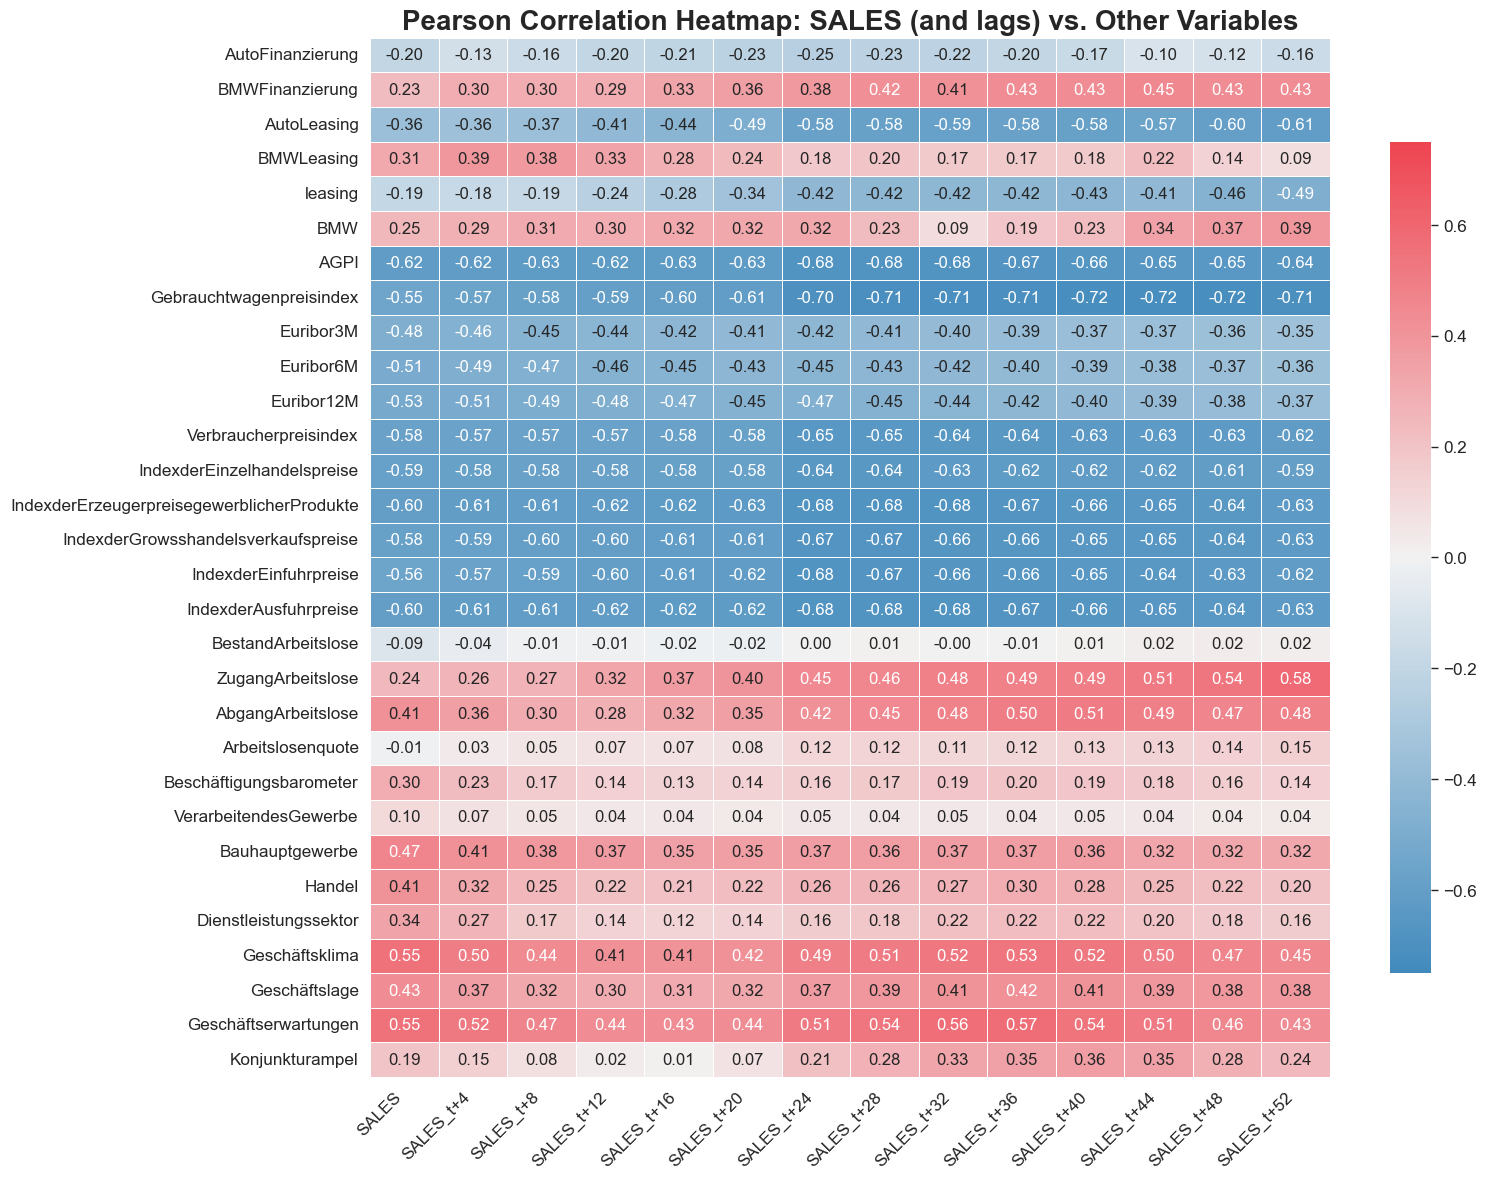


Pearson Correlation Subset:


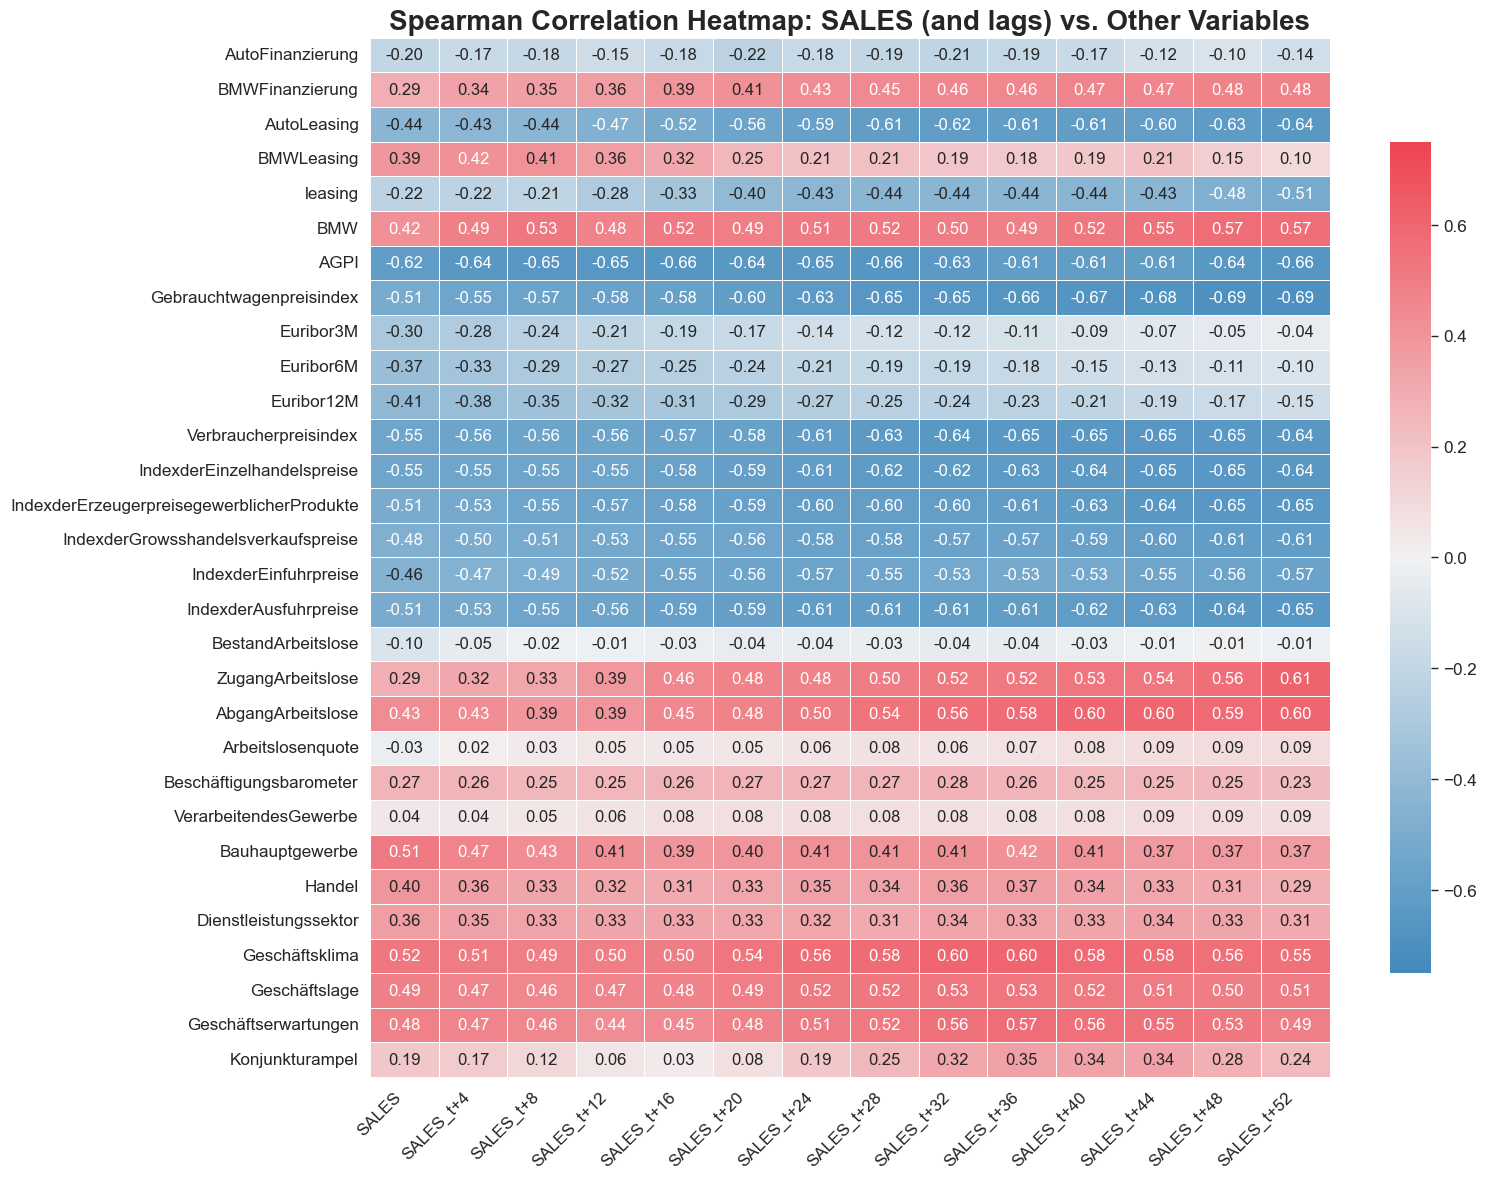


Spearman Correlation Subset:


In [20]:
target_cols = ["SALES"] + [f"SALES_t+{i}" for i in range(4, 53, 4)]
other_cols = [col for col in df_fe.columns if col not in target_cols + ["DATE"]]

correlation_methods = ["pearson", "spearman"]
for method in correlation_methods:
    correlation_matrix = df_fe[target_cols + other_cols].corr(method=method)
    correlation_subset = correlation_matrix.loc[other_cols, target_cols]

    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.4)
    custom_palette = sns.diverging_palette(
        240, 10, s=80, l=55, n=256, center="light", as_cmap=True
    )

    plt.figure(figsize=(16, 12))
    sns.heatmap(
        correlation_subset,
        annot=True,
        cmap=custom_palette,
        fmt=".2f",
        vmin=-0.75,
        vmax=0.75,
        center=0,
        annot_kws={"size": 12},
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
    )

    plt.title(
        f"{method.capitalize()} Correlation Heatmap: SALES (and lags) vs. Other Variables",
        fontsize=20,
        fontweight="bold",
    )

    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print(f"\n{method.capitalize()} Correlation Subset:")

In [21]:
# Lagged Correlations Cross-Correlation Function - CCF

In [22]:
# Correlation analysis